## Spike loading template
This template is for loading in spike data saved as phy formatted files that have already been manually curated using SortaSort2.

In [1]:
import os
import pynapple as nap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mimo_pack.fileio.loadphy import as_pynapple
from mimo_pack.preprocess.unit import pynapple_spikes_qc
from mimo_pack.plot.unit import probe_units

## Set directories and file paths
Enter the directories for the sorted and manually curated spike data files that are formatted for Phy. These will almost always be in the 'kilosort4' directory. To get spike waveforms and perform quality controls, you need to also provide the path for the dclut file corresponding to the probe containing your sorted spikes.

In [2]:
# Probe directory, should be on the server or the spike sorting drive on your local computer
probe_dir =['D:\\', 'SortingTemp', '24-05-31_DH23_A1-IC_g0', 
            '24-05-31_DH23_A1-IC_g0_imec0']

# save directory, should be on the analyses/data drive on your local computer
save_dir = ['D:', 'AudAD', 'project', 'data']

# your path to the phy directory goes here
phy_dir = os.path.join(*probe_dir, 'kilosort4')

# your path to the dclut file goes here
dcl_path = os.path.join(*probe_dir, probe_dir[-1].replace('_g0_', '_g0_t0.') 
                        + '.ap_dclut.json')

# your path to the su spike data goes here
su_path = os.path.join(*save_dir, probe_dir[-1].replace('_g0_', '_g0_t0_') 
                        + '.ap.su.npz')

# your path the the mu spike data goes here
mu_path = os.path.join(*save_dir, probe_dir[-1].replace('_g0_', '_g0_t0_') 
                        + '.ap.mu.npz')


## Load spikes and perform quality control
First load the spike data as a pynapple TsGroup object using `as_pynapple`. If you manually curated your spikes with SortaSort, those Phy files should end in a suffix ('_sas'). Be sure to specify that suffix.

In [3]:
spks = as_pynapple(phy_dir, dcl_file=dcl_path, verbose=True, suffix="_sas")

Loading phy files
Loading times from dclut file
Assigning spikes to clusters


Assigning: 100%|██████████| 701/701 [00:45<00:00, 15.39cluster/s]


Loading cluster classes
Getting spike waveform properties


Assigning: 100%|██████████| 701/701 [04:47<00:00,  2.44cluster/s]


Once the spikes are loaded, you can run quality control on them with `pynapple_spikes_qc`. When a report path is specified, pdfs of the spike quality control metrics and visualizations of the spike properties will be saved there. This directory is best placed in the kilosort4 directory that has the Phy formatted spike files.

In [ ]:
qc_report_path = os.path.join(phy_dir, "qc_reports")
spks_qc = pynapple_spikes_qc(spks, dcl_path, report_path=qc_report_path, verbose=True)

Loading dclut file: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec0\24-05-31_DH23_A1-IC_g0_t0.imec0.ap_dclut.json


Processing units:   3%|▎         | 23/701 [02:02<58:46,  5.20s/it]  

## Identify high-quality single units
Units in the pynapple object can be segregated into high and low quality single units based on the quality control metrics. The low quality single units, assuming they are not noise, can be combined with the multiunit spikes aleady identified during manually curation.

Two factors seem to be especially indicative of single unit quality.

1. *WaveformSpread*: how far out the spike waveform spreads to adjacent electrodes. Should be less than 100um
2. *RefractoryViolations*: the ratio of observed to expected (assuming poisson spiking) spikes within the refractory period. Should be less than 0.5.

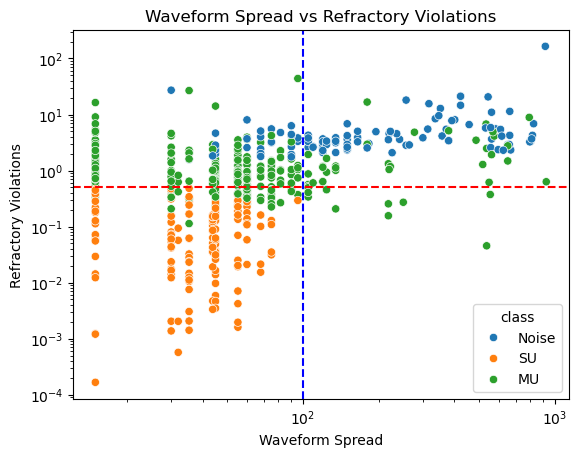

In [ ]:
spread_cutoff = 100  # Waveform spread threshold
refractory_cutoff = 0.5  # Refractory violations threshold
spks_meta = spks_qc.metadata

# Plot quality, add popup label to each point with index
fig, ax = plt.subplots(figsize=(10, 6))
# set color mapping for hue to be SU - orange, MU - green, Noise - blue
palette = {'SU': 'tab:orange', 'MU': 'tab:green', 'Noise': 'tab:blue'}
sns.scatterplot(data=spks_meta, x='WaveformSpread', y='RefractoryViolations', 
                hue='class', palette=palette, ax=ax)
ax.set_title('Waveform Spread vs Refractory Violations')
ax.set(xscale='log', yscale='log')
ax.set_xlabel('Waveform Spread')
ax.set_ylabel('Refractory Violations')
ax.axhline(y=refractory_cutoff, color='red', linestyle='--', label='Refractory Violations Threshold')
ax.axvline(x=spread_cutoff, color='blue', linestyle='--', label='Waveform Spread Threshold')

fig.savefig(os.path.join(qc_report_path, 'qc_spread_vs_refractory.pdf'))


Now reassign units into those that are high quality single units and all others as multi-units (excluding noise).

In [ ]:
class_new = spks_meta['class'].copy()
# Get su units, those with appropriate WaveformSpread < 100 and RefractoryViolations <= 0.5
su_index = spks_meta[(spks_meta['WaveformSpread'] < spread_cutoff) &
                   (spks_meta['RefractoryViolations'] <= refractory_cutoff) & 
                   (spks_meta['class'] == 'SU')].index

# get mu units, those not in su_index and whose class is not 'Noise'
mu_index = spks_meta[(~spks_meta.index.isin(su_index)) &
                     (spks_meta['class'] != 'Noise')].index


# replace the old class with the new one
class_new[su_index] = 'SU'
class_new[mu_index] = 'MU'
spks_qc.set_info(**{'class': class_new})

## Organization of units on probe
Plot the distribution of single and multiunits across the probe. This will provides a quick visual check that units are where they should be. For instance, areas of the probe with white matter should not show unit activities, or in cortex single units should have the widest waveform spread in layer 5.

<Axes: title={'center': 'Distribution of units on probe'}, xlabel='x position (um)', ylabel='y position (um)'>

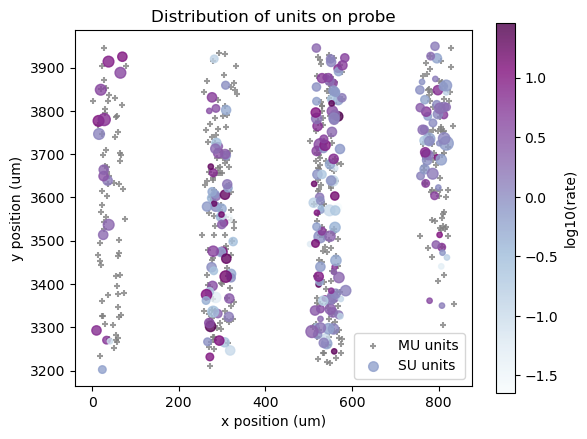

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
probe_units(spks_qc, cmap='BuPu', alpha=0.8, ax=ax)
fig.savefig(os.path.join(qc_report_path, 'qc_probe_units.pdf'))

## Save unit data
Once the units have been sorted into single and multi-unit TsGroup objects, we should save them for future use. You will have choosen a directory to save them to above. We will use the built-in save method in the TsGroup object, which saves the data as .npz files. Single unit and multiunit data are saved in separate files since more often than not you only want to load the single unit data.

In [ ]:
spks_su = spks_qc[spks_qc.get_info('class') == 'SU']
spks_mu = spks_qc[spks_qc.get_info('class') == 'MU']
spks_su.save(su_path)
spks_mu.save(mu_path)